<h1 align="center">TensorFlow Neural Network Lab</h1>

<img src="image/notmnist.png">
In this lab, you'll use all the tools you learned from Lesson 1 to label images of English letters! The data you are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in a different font.  You'll build a neural network to label the images as a letter, A-J.

The above images are a few examples of the data you'll be training on. After training the network, you will compare our prediction model against a separate set of data, called our test data. Your goal, by the end of this lab, is to make predictions against that test set with at least an 80% accuracy. Enough talking, let's jump in!

To start this lab, you first need to import all the necessary modules. Run the code below. If it runs successfully, it will print "`All modules imported`".

In [1]:
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


The notMNIST data is a large dataset to handle for most computers.  It contains 500 thousands images for just training.  You'll be using a subset of this data, 21,000 images for each label(A-J).

In [3]:
def download(url, file):
    """
    Download file from <url>
    """
    if not os.path.isfile(file):
        print('Downlading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Downlading notMNIST_train.zip...
Download Finished
Downlading notMNIST_test.zip...
Download Finished
All files downloaded.


In [4]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from zip file
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:01<00:00, 6364.07files/s]

All features and labels uncompressed.


<img src="image/mean_variance.png" style="height: 75%;width: 75%; position: relative; right: 5%">
## Problem 1
The first problem involves normalizing the features for our training and test data.  To normalize the data, you need to implement the `normalize()` function to apply zero mean and zero variance scale.

In [5]:
# Problem 1 - Apply zero mean and zero variance scale to the image features
def normalize(data):
    ???



### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])),
    np.array([-0.4, -0.3, -0.2, -0.099, 0.0, 0.099, 0.199, 0.3, 0.4, 0.5]),
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize(np.array([-100, -30, -1000, -20, -20, -10, -10, -20, -10, -10])),
    np.array([9.5, 2.5, 99.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5]))

train_features = normalize(train_features)
test_features = normalize(test_features)
is_features_normal = True

print('Tests Passed!')

Tests Passed!


In [6]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(test_labels)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [7]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encoded the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [8]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# Checkpoint
All your progress is now saved to the pickle file.  If you need to leave and comeback to this lab, you no longer have to start from the beginning.  Just run the code block below and it will load all the data and modules required to proceed.

In [9]:
%matplotlib inline

# Load the modules
import pickle

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memoy


print('Data and modules loaded.')

Data and modules loaded.


<img src="image/weight_biases.png" style="height: 60%;width: 60%; position: relative; right: 10%">
## Problem 2
For the neural network to train on our data, you need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - tensor should act as a place holder for feaure data(`train_features`/`valid_features`/`test_features`)
 - `labels`
  - tensor should act as a place holder for label data(`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - tensor should be initialized to random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - tensor should be initialized to all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

Note: For the `features` and `labels` tensors, you can use None to accept a dimension of any size.  You are batching the features and labels, so you should accept any number of samples.

In [10]:
features_count = 784
labels_count = 10

# Problem 2 - Set the features and labels tensors
features = ???
labels = ???

# Problem 2 - Set the weights and biases tensors
weights = ???
biases = ???



### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == (None) or features._shape == (None, 784), 'The shape of features is incorrect'
assert labels._shape == (None) or features._shape == (10), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Regression Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [11]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/learn_rate_tune.png" style="height: 60%;width: 60%">
## Problem 3
Tweak the learning rate, number of steps, and batch size to get a good accuracy.  The code will print out a Loss and Accuracy graph, so you can see how well the neural network performed.  To complete this final problem, you must get a accuracy of at least 80%.

100%|██████████| 1000/1000 [00:12<00:00, 79.03steps/s]


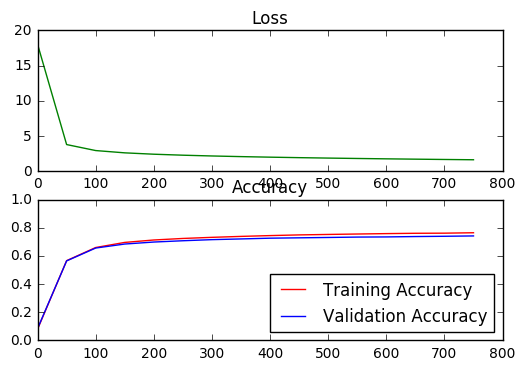

Nice Job! Test Accuracy is 0.8410000205039978


In [12]:
# Problem 3 - Tune the learning rate, number of steps, and batch size to get a good accuracy
learning_rate = ???
num_steps = ???
batch_size = ???



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the test set
test_accuracy = 0.0

# Measurements use for graphing loss and accuracy
steps = []
loss_steps = []
train_acc_steps = []
valid_acc_steps = []

with tf.Session() as session:
    session.run(init)

    # Progress bar
    steps_pbar = tqdm(range(num_steps), unit='steps')
    # The training cycle
    for step in steps_pbar:
        # Get a batch of training features and labels
        batch_start = step*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]
        
        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict={features: batch_features, labels: batch_labels})
        
        # Log every 50 steps
        if not step % 50:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

            # Log steps
            steps.append(step)
            loss_steps.append(l)
            train_acc_steps.append(training_accuracy)
            valid_acc_steps.append(validation_accuracy)

    # Check accuracy against Test data
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(steps, loss_steps, 'g')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(steps, train_acc_steps, 'r', label='Training Accuracy')
acc_plot.plot(steps, valid_acc_steps, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.legend(loc=4)
plt.show()

assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greate than 0.80'.format(test_accuracy)

print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

# One Layer to Two
One layer neural networks are great, but that's not why you're here.  This is deep learning after all!  In the next section, you will start to satisfy your need for more layers.